In [4]:
import numpy as np
import pandas as pd
from nltk import word_tokenize,sent_tokenize
from collections import deque
import random
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
#from tensorflow import Tensorboard

# Generating rap lyrics with recurrent neural networks

I wanted to create a RNN to produce rap lyrics inspired by Kany West (him because I found a clean dataset on Kaggle).

I will explain the code in some detail, but I won't describe the network structure in any detail, since I mostly write these notebooks for myself.

There are many other good sources online, where you can learn the basics of RNN.

The only thing I will say to begin with, is that we want to feed a set of 29 characters into a neural network, and make it predict what the next character should be. This prediction is made on the basis of what the structure of the input data (Kanye West lyrics) is; 

if Kanye often sings "blood on the", the network will give a high probability that the next letter after "blood on th" will be "e".

Here we import the data, and store the data as lists of lines, words and characters

In [240]:
filename = "kanye_verses.txt"

text = open(filename).read()
lines = text.splitlines()
words = word_tokenize(text.replace(" "," æ "))
characters = list(text)

This is how the raw textfile looks

In [241]:
text[0:100]

'Let the suicide doors up\nI threw suicides on the tour bus\nI threw suicides on the private jet\nYou kn'

And if we split it up in lines we get

In [242]:
lines[0:5]

['Let the suicide doors up',
 'I threw suicides on the tour bus',
 'I threw suicides on the private jet',
 "You know what that mean, I'm fly to death",
 "I step in Def Jam buildin' like I'm the shit"]

When we use word_tokenize, the function does not count spaces as words, so we replace the spaces with the norwegian letter " æ ", which I assume is not already in the text. Then we replace the word "æ" with " ", using list comprehension.

In [243]:
words[0:10]

['Let', 'æ', 'the', 'æ', 'suicide', 'æ', 'doors', 'æ', 'up', 'I']

In [244]:
words = [ " " if words[n] == "æ" else words[n] for n in range(len(words))]
words[0:10]

['Let', ' ', 'the', ' ', 'suicide', ' ', 'doors', ' ', 'up', 'I']

# Preprocessing

In [245]:
print(f"Data contains {len(words)} words, and {len(characters)} characters.")
print(f"There are {len(set(words))} unique words, and {len(set(characters))} unique characters")

Data contains 104854 words, and 260341 characters.
There are 7182 unique words, and 96 unique characters


That is a lot of unique words, so if we use-one-hot encoding (where each word is transormed to a vector with length equal to the number of unique words), the memory of my laptop can't handle that amount of data. Therefore, we will build a character-level model. The method for creating a word-level model, is almost exactly the same.

 We take the first 20 000 characters, which is enough data for this proof-of-concept project.

In [249]:
num_letters = 20000
X = list(characters[:num_letters])
unique = sorted(list(set(X)))
len(unique)

80

In this subset of the full dataset, there are 80 unique characters. Since we will use one-hot-encoding, we need two dictionaries: one that maps the character to vector indices, and one that maps from vector indices to characters. This is done below, where we also verify that the dictionary works by translating index 0 to its character representation and then back to index representation.

In [250]:
ind_to_letter = dict((i, j ) for i, j in enumerate(unique))
ind_to_letter[0]

'\n'

In [251]:
letter_to_ind = {unique[n]:n for n in range(len(unique))}
letter_to_ind['\n']

0

Now we create a function to perform the one-hot-encoding. One-hot-encoding can be illustrated by using the example text "abc". We want to encode it into a vector of length 3, since there are 3 unique letters in this example. One way to do that is simply

$$ a \to [1,0,0] ,\quad b \to [0,1,0], \quad c \to [0,0,1] $$

and an equally valid encodig is

$$ a \to [0,1,0] ,\quad b \to [0,0,1], \quad c \to [1,0,0] $$

The idea is that we have one unique vector for every character. And since we have created two dictionaries, which maps between indices and characters, we can use this to transform the dataset (which is now a list of characters), into a list of vectors (each representing a uniqe character). This is done in the function below

In [252]:
def one_hot_encode(X,unique):

    X_one_hot = []                         # Empty list which we will append the o-h-encoded vectors to.
    for n in range(len(X)):
        one_hot = [0]*len(unique)          # Create a vector of 0's, with length equal to number of uniqe letters.
        one_hot[letter_to_ind[X[n]]] = 1   # Map the character X[n] to its index, and insert 1 at that index.
        X_one_hot.append(one_hot)          # Append the vector to the list
        
    return X_one_hot

In [253]:
X_one_hot = one_hot_encode(X,unique)

Now we must decide how many characeters in the past the network should look, to determine what the next character should be. With a longer memory, training takes more time, but it would also result in more coherent output. Let's set the memory length to 30 characers.

We split the data into sequences of 30 characters, which will be the input of the neural network. We could train sequentially on the full dataset (i.e, put the 30 first characters into the network, then the characters from 1:31, then 2:32, etc.) but since the input data (lyrics) has very strong sequential correlation, this would result in inefficient training: In the beginning of training, the network would be fitted to the first verses, but since the language structure of later songs can change drastically from the first songs, the network would be unable to coverge to a good minimum.

In [254]:
memory_length = 30

sequence = deque(maxlen = memory_length)            # Create a deque, essentially a fixed length list,
                                                    # which automatically removes first element
                                                    # to make place for newer inputs
sequential_data = []

for n in range(len(X_one_hot)):
    sequence.append(X_one_hot[n])                   # Append o-h-vectors to a sequence
    if len(sequence) == memory_length:
        sequential_data.append(np.array(sequence))  # Once we have a full deque, add the sequence to data


Just as a sanity check, we check if we con convert the first index of the first sequence from its o-h-vector form to the correct character. Since we get "L", which is also the first letter of the input data, we are happy.

In [255]:
# Test if everything is ok so far
ind = list(sequential_data[0][0]).index(max(list(sequential_data[0][0])))
ind_to_letter[ind]

'L'

Now we shuffle the data to remove the time-correlation of the sequences, and split the data into training and validation sets.

In [256]:
random.shuffle(sequential_data)

training_frac = 0.1
index = int(training_frac*len(sequential_data))


train_data = sequential_data[:-index]
test_data = sequential_data[-index:]

Our goal is to predict the last character in a sequence of 30 characters. The target data which will compare our predictions to, is therefore the last character of every sequence. Here we extract these targets from the data, and define our inputs X, and target outputs y, for both the training and validation data.

In [257]:
def target_data_split(data):
    X = [None]*len(data)
    y = [None]*len(data)
    
    for n in range(len(data)):
        X[n], y[n] = data[n][:-1], data[n][-1]        # Separate the first 29 characters and the last character
    return np.array(X), np.array(y)                   # for every sequence.

X_train, y_train = target_data_split(train_data)      
X_test, y_test = target_data_split(test_data)


We are now ready to create the neural network, and start training. The network structure is a long-short-term-memory (LSTM) layer, then a dense layer, followed by a final output layer with softmax activation (since we want the proability distribution of the next letter as output).

In [18]:
model = Sequential()

model.add(LSTM(128, input_shape = (np.array(X_train)[0].shape)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(len(unique), activation = "softmax"))

optimizer = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["acc"])

In [ ]:
model.summary()

In [19]:
epochs = 10
batch_size = 128
history = model.fit(X_train,y_train, batch_size = batch_size, epochs=epochs,validation_data=(X_test,y_test))

Train on 17974 samples, validate on 1997 samples
Epoch 1/10
17974/17974 [==============================] - 19s 1ms/step - loss: 2.7154 - acc: 0.2764 - val_loss: 2.5405 - val_acc: 0.3195
Epoch 2/10
17974/17974 [==============================] - 19s 1ms/step - loss: 2.2838 - acc: 0.3508 - val_loss: 2.2796 - val_acc: 0.3716
Epoch 3/10
17974/17974 [==============================] - 22s 1ms/step - loss: 2.1402 - acc: 0.3860 - val_loss: 2.1227 - val_acc: 0.3861
Epoch 4/10
17974/17974 [==============================] - 18s 982us/step - loss: 2.0367 - acc: 0.4049 - val_loss: 2.0493 - val_acc: 0.4206
Epoch 5/10
17974/17974 [==============================] - 18s 979us/step - loss: 1.9507 - acc: 0.4267 - val_loss: 1.9953 - val_acc: 0.4146
Epoch 6/10
17974/17974 [==============================] - 18s 985us/step - loss: 1.8680 - acc: 0.4455 - val_loss: 1.9349 - val_acc: 0.4452
Epoch 7/10
17974/17974 [==============================] - 18s 986us/step - loss: 1.8042 - acc: 0.4662 - val_loss: 1.9841 - 

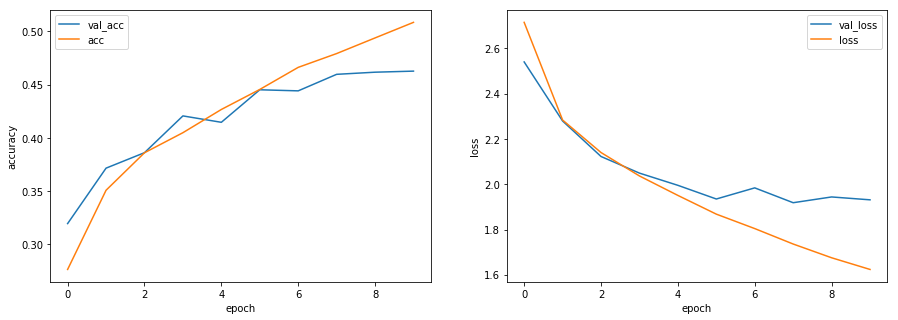

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,5))

epochs

plt.subplot(1,2,1)
plt.plot(history.history["val_acc"])
plt.plot(history.history["acc"])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["val_acc","acc"])

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["val_loss","loss"])


After traning for 10 epochs, we see that the validation accuracy and validation loss starts to stabilize, so its a good time to stop.

Now we have a model which takes 29 characers as an imput, and gives one proability distribuion of all possible next characters as output.

What we need next, is a function that takes 29 seed characters, the desired length of the output, and a temperature (to be explained later) as input. As the output we want a generated text, where the AI tries to imitate Kanye West. A function that does this is defined below

In [129]:
def generate_rap(seed_sentence:str, length:int , temperature:int, memory=memory_length-1):
    
    cut_seed = list(seed_sentence[:memory])           # We cut the input seed (a user defined string)
                                                      # so that it is the same length as our sequence.
    for n in range(len(cut_seed)):
        if cut_seed[n] not in ind_to_letter.values():
            print("Unkown character in input")
            return False                              # Report an error if there is a character we havent seen
    
    o_h_seed = np.array(one_hot_encode(cut_seed,unique))  # one-hot-encode the seed
    o_h_sentence = []
    
    for n in range(len(o_h_seed)): 
        o_h_sentence.append(o_h_seed[n])                 # append the seed to the output
        
    o_h_seed = o_h_seed.reshape(1,memory,len(unique))
    
    
    for n in range(length):
    
        next_letter = model.predict(np.array(o_h_seed))[0]       # get a model prediction
                            
        next_letter = boltzmann_sample(next_letter,temperature)  # sample probability distribution(see below)
        
        o_h_sentence.append(next_letter)                        # append the letter to the output
  
        next_letter = np.reshape(next_letter, (1,) + next_letter.shape)

        o_h_seed = np.concatenate((o_h_seed,next_letter), axis = 1)  # add the new letter to the seed
        o_h_seed = np.delete(o_h_seed,obj=0,axis=1)                  # and delete first letter of seed
                                                                     # to keep seed length = 29
            
    str_sentence = ""
    for n in range(len(o_h_sentence)):
        str_sentence += ind_to_letter[np.argmax(o_h_sentence[n])]   # translate the o-h-data to string
    
    print(str_sentence)
    
    
    return o_h_sentence

The way we sample the next letter from the output probability distribution deserves special attention. If we always used the max index value of the output, we would quickly be stuck in a loop i.e. "blood on the blood on the blood" (see below).

We transform the output probability distribution, $p$ into the Boltzmann distribution, $q$:

$$  q_i = \frac{\exp[~\ln(p_i)/T~]}{\sum_i^N \exp[~\ln(p_i)/T~]}, $$

where N is the length of the one-hot-vector output (i.e. the number of unique characters) and T is a parameter. In physics this distribution is the one of a system at equilibrium with temperature T. 

If T = 1, we see that we get back the original probability distribution $q_i = p_i$.

If we sample from this distribution, the temperature T determines how likely we are to sample values with high value of  $p_i$. 


For large $T>>1$, we get a uniform distribution

$$ q_i = 1/N$$

and therefore indpendent on the input $p_i$. This means that we are equally likely to draw any of the possible characters when sampling.


For small $T<<1$, the exponential disribution becomes a delta function, centered on the largest $p_i$

$$ q_i = \delta(p_i-\max(p)) $$

all $q_i$ except for one is zero, while the $q_i$ with the largest $p_i$ as input becomes 1. That is, the zero temperature sampling, is equivalent to always choosing the letter with the largest probability in the output distribution $p$.

In [263]:
def boltzmann_sample(probs, temperature=1.0):
    probs = np.asarray(probs).astype('float64')
    
    probs = np.exp(np.log(probs) / temperature)
    normalization = np.sum(probs)
    
    probs = probs / normalization
    
    sample = np.random.multinomial(1, probs, 1)
    return sample

Below we generate sample texts, while using different temperatures for our sampling.

For low temperatures, where we mostly choose the character with highest probability, we get stuck in loops, such as "the blood on the blood on the blood....". However, the spelling of the words are correct. The overall structure of the text is repetative, but the words are 

For high temperatures, we get mostly random letters. Most of the words have no meaning, but the text is very diverse.

For intermidate temperatures, we get more coherent sentence structures, and also more diverse word usage.
<img src="golden_zone.png" alt="Drawing" style="width: 500px;"/>

Kanye is more of a singer than a rapper. I'm not very happy with the output, as it seems more like the ramblings of a very angry person, than actual rap lyrics.

Next I want to do the same project on someone like MF Doom, which is one of the most verbose and rhyming rappers.
If that does not produce what I want, I will try to combine this model with deep reinforcement learning, so I could do something like taking the output from this model as the input of an DQL agent, and give it reward based on rhyming, sentence structure, etc. Maybe make a haiku-rap generator?


In [264]:
temperature = 0.1
length = 1000
seed = "Soon as they like you make 'em unlike you"
test = generate_rap(seed,length,temperature)

Soon as they like you make 'em the did I know they the blood on the blood on the blood on the blood on the blood on the blood on the blood on the did I know they the blood on the blood on the blood on the blood on the blood on the blood on the blood on the blood on the blood on the blood on the blood on the blood on the blood on the blood on the blood on the blood on the blood on the blood on the with the blood on the blood on the blood on the blood on the blood on the blood on the blood on the blood on the blood on the blood on the blood on the blood on the blood on the blood on the blood on the blood on the blood on the blood on the first flese
I said be all the blood on the blood on the blood on the blood on the blood on the did I still the blood on the blood on the blood on the blood on the blood on the blood on the blood on the blood on the first flese
I said niggas still first fince fince fince first first fince first like I was the blood on the blood on the blood on the blood on

In [142]:
temperature = 0.25
length = 1000
seed = "Soon as they like you make 'em unlike you"
test = generate_rap(seed,length,temperature)

Soon as they like you make 'em like I was all that I got the money and my black to flem best
But I don't fuck now
I said niggas fince fince fly niggas the did I'm 'em like I the came they gon' clontil the blood a ding the blood to the get the blood on the blood still fince first flen me with the blood the did I still me find this the still first flese
I said niggas come on this the don't first from the pleas for the blood on this the please I broke me find this best
I tried you her all the come find shit niggas some be like I wont the blood still figen this the dill on this the mone still and the get the blood on the blood some with the bitch the blood on the fuck niggas and same this think the blood on the veame finst sfirst persed to the did niggas the gon we the blood they said stell fuck the blead the blood on the got the blood a did niggas find first me
I don't fuck with the blood a did some fince first lest
I said you know I don't first fuck niggas like I'm fink they first nad th

In [143]:
temperature = 0.5
length = 1000
seed = "Soon as they like you make 'em unlike you"
test = generate_rap(seed,length,temperature)

Soon as they like you make 'em the did the blood on the blood on the pless best
I know you wast the blood on the blood on the blood on the blood on the did I know they the blood on the money the blood on the blood on the first fuck now I know they the blood on the blood on the blood on the blood on the blood on the blood on the blood on the pleave I still the blood on the blood on the blood on the blood on the did I still some be first flest
I still first flest I still first fince first flest
I still first first fince first fince first fince first fince first fince first fack to with the blood on the blood on the blood on the blood on the blood on the blood on the blood on the blood on the blood on the blood on the blood on the blood on the first flese
I said niggas the blood on the blood on the blood on the blood on the blood on the first flese
I said niggas some be first flest
I still me the blood on the first flest
I still the blood on the blood on the blood on the blood on the stre

In [146]:
temperature = 0.75
length = 1000
seed = "Soon as they like you make 'em unlike you"
test = generate_rap(seed,length,temperature)

Soon as they like you make 'em my first hed on we lim us and it's un all thouse thow I'm a evel
And niggas be
Twas that new resens

I know I came ma press niggas to cound’s this they need that Trray? bitch niggas ass Bome
And never me
This bitch for ad I've been and this these me talk you

Stuck niggas ain't from niggas somebody
Wann know me cast find lex
And I told my finl my prigos 'em ofty be to vick still stanks the flew it
So vew tise that Beption te with I talk then percen find lew Mibss
These nam like I my famous Ban, nigga
I the right so shat
Loke Mass in this this the bell niggas came out talk the pissty
He blood all they give like this that's be all the clottin' like I've been me like I best
I told 'em like I with the I wonst llwoon eelin's pridce
Fuck the Kansing you bad the plet this sish first gradye
My mildy where to treal right now
Ast ay, Ky, I we fored you could've been want to want to troke but the stail the like talk abious pods, paing ony
Beto is tellime you to try 

In [147]:
temperature = 1.2
length = 1000
seed = "Soon as they like you make 'em unlike you"
test = generate_rap(seed,length,temperature)

Soon as they like you make 'em like welchsHirs, rubp wnink to Banlway, you from you did sssDatday, ild-
Yuall 'bout the still first niggas Recil
Ludt to way flive ?
dyragnt shigh Tlincus comone lom pegne sTads hiall mop like ya Roke SRive Beswas fot the kI blowd so knew ReckSIGcst first fy5s his fof with of the Myurn, down get fuck
Blaw
I'm bottall  ugas nigga
zy
Niggas grk first nw!
ef to sutide I can't fminno shreAs tun like éwe light pain high fuck
Souny link the I know scould 0
L's new slaves
I'm 'bout to girln rightnno  witce
KGod this fisk qlest
Wioke you prozent is to lowe
Youn out fitty colnsmy with Li gh out like I this tastoney
SraRd, Ye’TC y, Ron s at
What finks Blaevin' ree 'sking on I've been lem me owe Cty’al 'be been cloome gigl buutin' one cutpN brock tusios wave I talk thar niggas mon that Fuck buck lidton is proston my
Ittall bobied 'bout it cillyso rep
Wass like I'm rockin' tI fussy lep cut
1't live benna call in all, wasn'll Je lome
Dunk thill wants looking Chodoh
A